In [4]:
import sys
sys.path.append('./models/results')
import matplotlib.pyplot as plt
import numpy as np
# import dida_caps_not_clean, dida_spinal_not_clean, historical_spinal_not_clean, historical_caps_not_clean
from json import load

labels = ['baseline', 'standard', 'binarized']
folder_path = './imgs/'
plt.rcParams.update({'font.size': 28})

def plot_character_accuracy(accuracy_dicts, labels, title= "", file_name="test"):

    save_path = folder_path + file_name

    if len(accuracy_dicts) != len(labels):
        raise ValueError("The number of dictionaries and labels must be the same.")
    
    sorted_data = []
    for accuracy_dict in accuracy_dicts:
        sorted_data.append(dict(sorted(accuracy_dict.items())))

    characters = list(sorted_data[0].keys()) 
    accuracies = [list(data.values()) for data in sorted_data]
    y_limit = max(max(acc) for acc in accuracies) * 1.1

    bar_width = 0.2
    x_positions = np.arange(len(characters))

    plt.figure(figsize=(14, 7))
    for i, acc in enumerate(accuracies):
        plt.bar(x_positions + i * bar_width, acc, bar_width, label=labels[i])
    
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("Accuracy")
    plt.ylim(0, y_limit)
    plt.xticks(x_positions + (len(accuracy_dicts) - 1) * bar_width / 2, characters, rotation=0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

In [5]:
files = ["json/capsnet_dida_clean_raw_class_accuracy.json", "json/capsnet_dida_clean_roi_class_accuracy.json", "json/capsnet_dida_clean_binary_class_accuracy.json"]
dicts = []

for file in files:
    with open(file) as f:
        dicts.append(load(f))

plot_character_accuracy(
    accuracy_dicts= dicts, 
    labels= labels, 
    title= "CapsNet Model on DIDA", 
    file_name= "dida_caps_clean.pdf")

In [6]:
files = ["json/spinalnet_dida_clean_raw_class_accuracy.json", "json/spinalnet_dida_clean_roi_class_accuracy.json", "json/spinalnet_dida_clean_binary_class_accuracy.json"]
dicts = []

for file in files:
    with open(file) as f:
        dicts.append(load(f))

plot_character_accuracy(
    accuracy_dicts= dicts, 
    labels= labels, 
    title="SpinalNet Model on DIDA", 
    file_name="dida_spinal_clean.pdf")

In [7]:
files = ["json/spinalnet_historical_clean_raw_class_accuracy.json", "json/spinalnet_historical_clean_roi_class_accuracy.json", "json/spinalnet_historical_clean_binary_class_accuracy.json"]
dicts = []

for file in files:
    with open(file) as f:
        dicts.append(load(f))

plot_character_accuracy(
    accuracy_dicts= dicts, 
    labels= labels, 
    title="SpinalNet Model on Historical Dataset", 
    file_name="historical_spinal_clean.pdf")

In [8]:
files = ["json/capsnet_historical_clean_raw_class_accuracy.json", "json/capsnet_historical_clean_roi_class_accuracy.json", "json/capsnet_historical_clean_binary_class_accuracy.json"]
dicts = []

for file in files:
    with open(file) as f:
        dicts.append(load(f))

plot_character_accuracy(
    accuracy_dicts= dicts, 
    labels= labels, 
    title="CapsNet Model on Historical Dataset", 
    file_name="historical_caps_not_clean.pdf")

In [55]:
import os
import random
import shutil
import pandas as pd

def qualitative_images(dataset_folder, cvs_file, output_folder, num_samples=30):
    """
    Select a specified number of random images from the dataset across all classes.
    """
    
    misclassifications = pd.read_csv(cvs_file, header=0, names=["image", "predicted", "true"])
    misclassifications["image"] = misclassifications["image"].str.replace("\\", "/")
    misclassified_images = misclassifications[misclassifications["predicted"] != misclassifications["true"]]
    grouped_by_class = misclassified_images.groupby("true")

    selected_images = []
    all_classes = list(grouped_by_class.groups.keys())
    random.shuffle(all_classes)

    for class_name in all_classes:
        class_images = grouped_by_class.get_group(class_name)["image"].tolist()
        if class_images:
            selected_img_path = random.choice(class_images)
            print(selected_img_path)
            selected_images.append((selected_img_path, class_name))

    os.makedirs(output_folder, exist_ok=True)
    for img_path, true_class in selected_images:

        base_name = os.path.basename(img_path)
        if true_class.isdigit():
            new_file_name = f"{true_class}_{base_name}"
        else:
            new_file_name = base_name
        new_file_path = os.path.join(output_folder, new_file_name)
        shutil.copy(img_path, new_file_path)

    """ class_to_images = {}
    for class_name in os.listdir(dataset_folder):
        class_folder = os.path.abspath(os.path.join(dataset_folder, class_name))
        if os.path.isdir(class_folder):
            file_paths = [
                os.path.abspath(os.path.join(class_folder, file))
                for file in os.listdir(class_folder)
                if os.path.isfile(os.path.join(class_folder, file))
            ]
            if file_paths:
                class_to_images[class_name] = file_paths

    selected_images = []
    selected_classes = list(class_to_images.keys())
    random.shuffle(selected_classes)
    for class_name in selected_classes[:min(num_samples, len(selected_classes))]:
        img_path = random.choice(class_to_images[class_name])
        selected_images.append((img_path, class_name))


    os.makedirs(output_folder, exist_ok=True)
    for img_path, class_name in selected_images:
        new_file_path = os.path.join(output_folder, f"{class_name}.jpeg")
        shutil.copy(img_path, new_file_path) """

    return [new_file_path for _, new_file_path in selected_images]

In [5]:
from PIL import Image
import transforms as ts
from importlib import reload
reload(ts)

def apply_transform_to_images(raw_images, qualitative_path, transformed_folder, roi = True, invert = True, binary = True):
    """
    Apply the EMNIST transform to a list of images and save the transformed images.
    """
    os.makedirs(transformed_folder, exist_ok=True)
    transformed_file_paths = []

    for raw_path in raw_images:

        image = np.array(Image.open(f"{qualitative_path}/{raw_path}"))
        transformed_image = ts.emnist_transform(image, roi, invert, binary)

        transformed_file_name = f"transformed_{os.path.basename(raw_path)}.jpeg"
        transformed_file_path = os.path.join(transformed_folder, transformed_file_name)
        Image.fromarray((transformed_image * 255).astype(np.uint8)).save(transformed_file_path)
        transformed_file_paths.append(transformed_file_path)

    return transformed_file_paths

In [6]:
def make_grid(image_paths, grid_size=(5, 5), save_path=None, title="Image Grid"):
    
    rows, cols = grid_size
    plt.figure(figsize=(15, 15))
    plt.suptitle(title, fontsize=20)
    
    for idx, img_path in enumerate(image_paths):
        img = np.array(Image.open(img_path))
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)
        plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [56]:
dataset_folder = "./datasets/HISTORICAL-clean"
output_folder = "./datasets/QUALITATIVE"
cvs_file = "capsnet_historical_clean_binary_results.csv"
selected_images = qualitative_images(dataset_folder, cvs_file, f"{output_folder}/RAW", num_samples=30)

print(f"Selected images saved to {output_folder}")

#transformed_images = apply_transform_to_images(selected_images, f"{output_folder}/RAW", f"{output_folder}/BINARIZED", roi = True, invert = True, binary = True)
#transformed_images = apply_transform_to_images(selected_images, f"{output_folder}/RAW", f"{output_folder}/STANDARD", roi = True, invert = True, binary = False)

datasets/HISTORICAL-clean/K/1523.jpg
datasets/HISTORICAL-clean/F/3339.jpg
datasets/HISTORICAL-clean/I/2880.jpg
datasets/HISTORICAL-clean/0/0_22228.jpg
datasets/HISTORICAL-clean/A/313.jpg
datasets/HISTORICAL-clean/9/9_18319.jpg
datasets/HISTORICAL-clean/3/3_10491.jpg
datasets/HISTORICAL-clean/B/33 - Copy - Copy (4) - Copy.jpg
datasets/HISTORICAL-clean/Q/55.jpg
datasets/HISTORICAL-clean/6/6_11093.jpg
datasets/HISTORICAL-clean/1/1_15662.jpg
datasets/HISTORICAL-clean/P/2525.jpg
datasets/HISTORICAL-clean/C/1774.jpg
datasets/HISTORICAL-clean/4/4_11281.jpg
datasets/HISTORICAL-clean/5/5_5022.jpg
datasets/HISTORICAL-clean/2/2_24401.jpg
datasets/HISTORICAL-clean/H/468.jpg
datasets/HISTORICAL-clean/S/2775.jpg
datasets/HISTORICAL-clean/8/8_7250.jpg
datasets/HISTORICAL-clean/D/d2 (1752).jpg
datasets/HISTORICAL-clean/E/e1 (2928).jpg
datasets/HISTORICAL-clean/7/7_4306.jpg
datasets/HISTORICAL-clean/L/2071.jpg
datasets/HISTORICAL-clean/T/2785.jpg
datasets/HISTORICAL-clean/M/1645.jpg
datasets/HISTORICAL

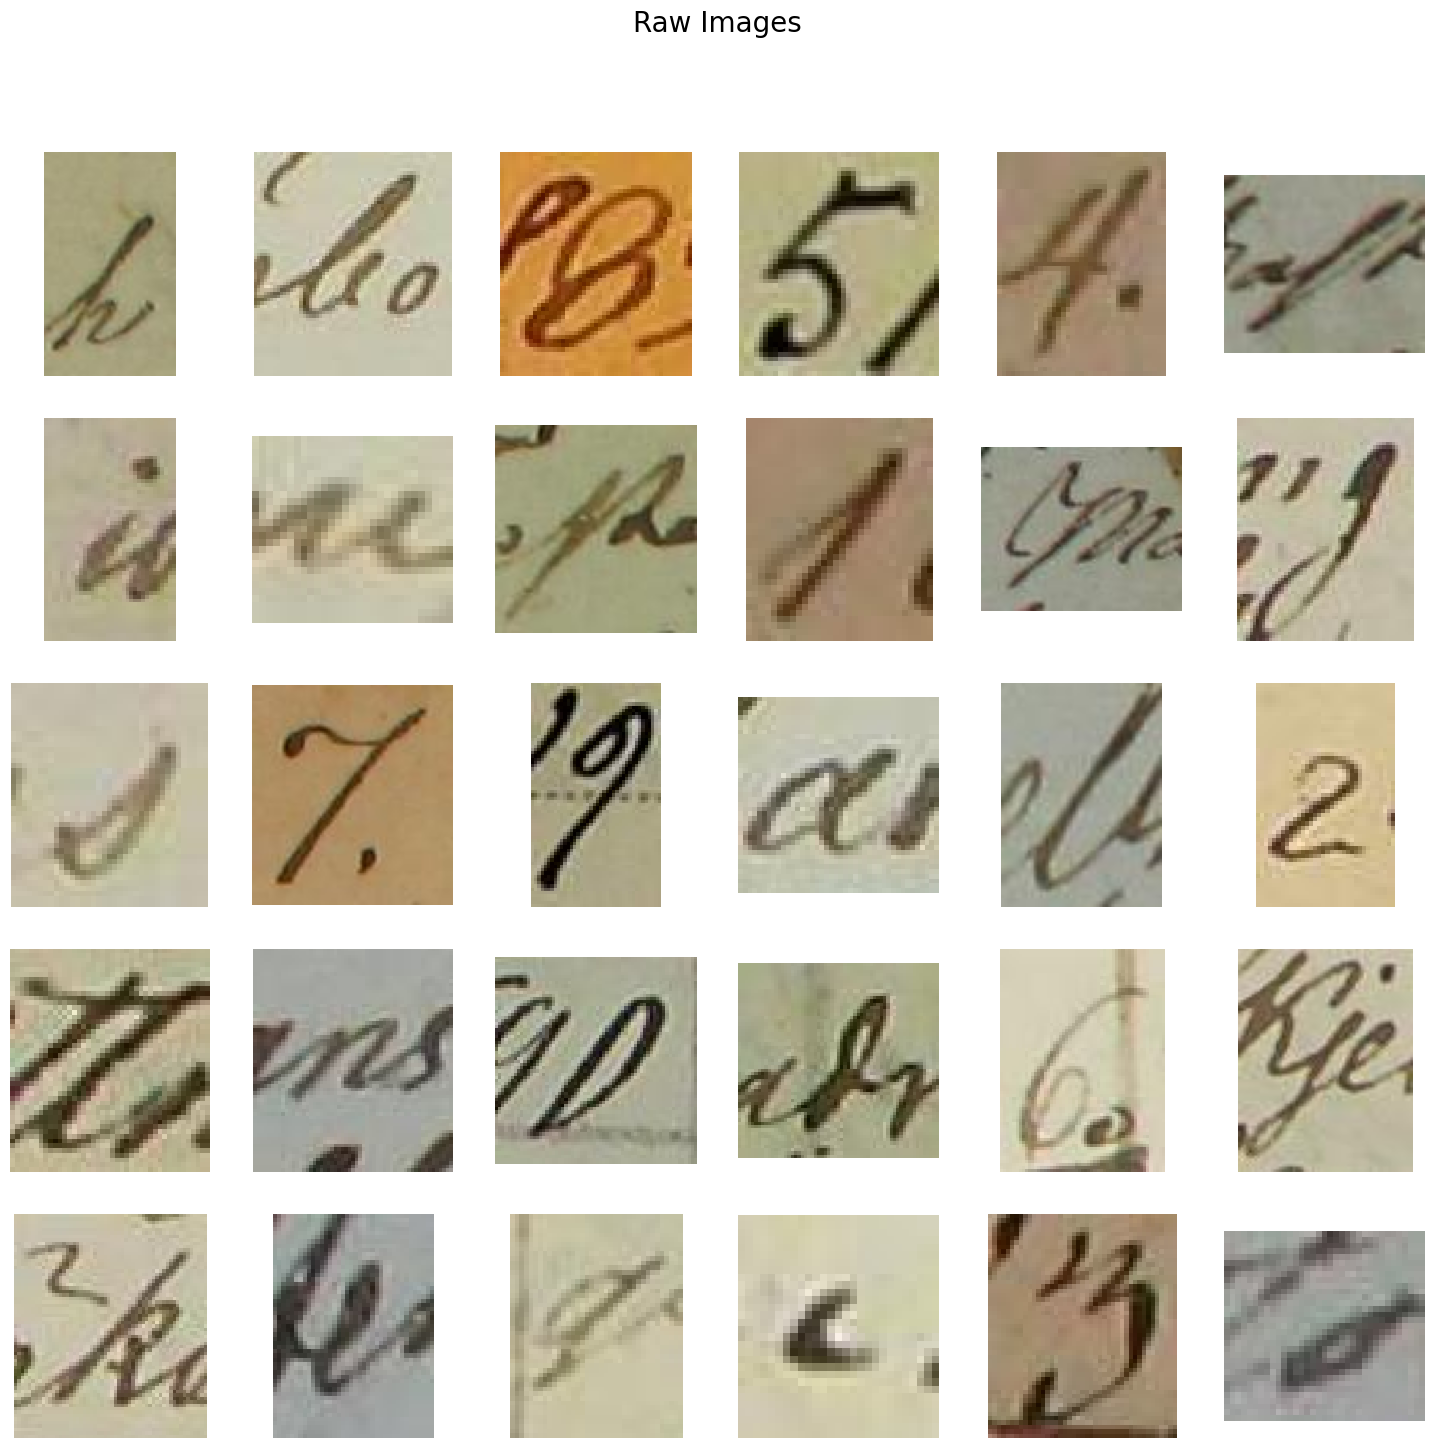

In [57]:
raw_image_paths = [os.path.join(f"{output_folder}/RAW", img) for img in os.listdir(f"{output_folder}/RAW")]
#binary_image_paths = [os.path.join(f"{output_folder}/BINARIZED", img) for img in os.listdir(f"{output_folder}/BINARIZED")]
#standard_image_paths = [os.path.join(f"{output_folder}/STANDARD", img) for img in os.listdir(f"{output_folder}/STANDARD")]
img_grid_path = "./imgs/qualitative_form"
# Grid size (e.g., 5x5 for 25 images)
grid_size = (5, 6)

# Create grids
make_grid(raw_image_paths, grid_size, save_path=f"{img_grid_path}/raw_grid.png", title="Raw Images")
#make_grid(binary_image_paths, grid_size, save_path=f"{img_grid_path}/binary_grid.png", title="Binary Images")
#make_grid(standard_image_paths, grid_size, save_path=f"{img_grid_path}/standard_grid.png", title="Standard Images")